In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
from itertools import count
from models.unet import unet
from settings import s
import time
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import dataloader
import json
from skimage import color
import matplotlib.pyplot as plt
from matplotlib import path
from color_discretizer import *

In [2]:
x=np.linspace(-110,110,9,True,dtype=int)
gridlab=np.vstack(map(np.ravel, np.meshgrid(x,x))).T
g=x*np.ones((1,len(x))).T
g=np.stack((g,np.rot90(g)))

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [3]:
spectrum = np.zeros([256,256*6, 3], dtype=np.uint8) # init the array
# fill the array with rgb values to create the spectrum without the use of loops
spectrum[:,:,0] = np.concatenate(([255]*256, np.linspace(255,0,256), [0]*256, [0]*256, np.linspace(0,255,256), [255]*256), axis=0)
spectrum[:,:,1] = np.concatenate((np.linspace(0,255,256), [255]*256, [255]*256, np.linspace(255,0,256), [0]*256,[0]*256), axis=0)
spectrum[:,:,2] = np.concatenate(([0]*256, [0]*256,np.linspace(0,255,256),[255]*256, [255]*256, np.linspace(255,0,256)), axis=0)
labspec=color.rgb2lab(spectrum/255)[0]

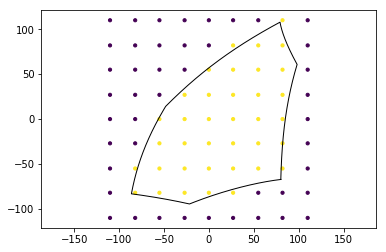

37


In [4]:
first = -110
size  = (110-first)/100

xv,yv = np.meshgrid(x,x)# np.meshgrid(np.linspace(-110,110,100),np.linspace(-110,110,100))
#p = path.Path([(-30,-10), (-50, 20), (10, 10), (30, 0)])  # square with legs length 1 and bottom left corner at the origin
p=path.Path(labspec[:,1:][::-1])
flags = p.contains_points(np.hstack((xv.flatten()[:,np.newaxis],yv.flatten()[:,np.newaxis])),radius=-15)
grid = np.zeros((101,101),dtype='bool')
grid[((xv.flatten()-first)/size).astype('int'),((yv.flatten()-first)/size).astype('int')] = flags

#xi,yi = np.random.randint(-300,300,100)/3,np.random.randint(-300,300,100)/3
xi,yi=gridlab[:,0],gridlab[:,1]
vflag = grid[((xi-first)/size).astype('int'),((yi-first)/size).astype('int')]
#plt.imshow(grid.T,origin='lower',interpolation='nearest',cmap='binary',extent=[-labspace.shape[1]*5., labspace.shape[1]*5., -labspace.shape[0]*5., labspace.shape[0]*5. ])
#plt.scatter(((xi-first)/size).astype('int'),((yi-first)/size).astype('int'),c=vflag,s=10)
plt.scatter(xi,-yi,c=vflag,s=10)
plt.axis('equal')
plt.plot(labspec[:,1],-labspec[:,2],color='k',lw=1)
plt.show()
print(np.count_nonzero(flags))

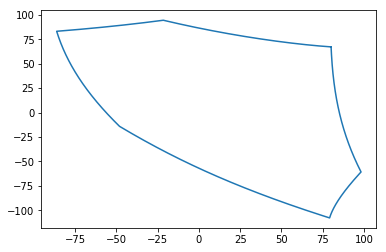

In [56]:
plt.plot(*labspec[:,1:].T)

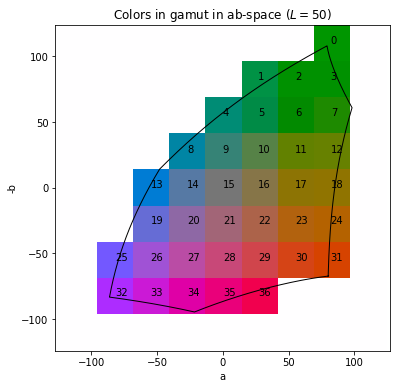

In [18]:
from skimage.transform import pyramid_expand
plt.figure(figsize=(6,6))
binsize=np.gradient(x).mean()
L=np.ones((1,len(x),len(x)))*50
labspace=np.concatenate((L,g)).transpose(2,1,0)
labspace=np.fliplr(labspace)
labspace_w=np.ones_like(labspace)*np.array([100,0,0]).reshape(1,1,3)
labspace_w[vflag.reshape(len(x),len(x))]=labspace[vflag.reshape(len(x),len(x))]
rgbrep=color.lab2rgb(pyramid_expand(labspace_w,binsize,0,0))
#rgbrep[rgbrep==np.zeros(3)]=np.ones_like(np.count_nonzero(rgbrep==np.zeros(3)))
plt.imshow(rgbrep,extent=[-labspace.shape[1]*binsize/2, labspace.shape[1]*binsize/2, -labspace.shape[0]*binsize/2, labspace.shape[0]*binsize/2 ])
#plt.plot(labspecfromxyz[:,1]+127,127+labspecfromxyz[:,2],color='k',lw=1)
plt.plot(labspec[:,1],-labspec[:,2],color='k',lw=1)
plt.axis('equal')
#plt.gca().grid(which='minor', color='w', linestyle='-', linewidth=2)
plt.xlabel('a')
plt.ylabel('-b')
plt.title('Colors in gamut in ab-space $(L=%i)$'%L.flatten()[0])
#plt.savefig('figures/labgamut-bins.pdf')
bins=labspace[vflag.reshape(len(x),len(x))][:,1:]
for i in range(len(bins)):
    plt.text(bins[i][1],-bins[i][0],i)
plt.show()

In [19]:
bins=labspace[vflag.reshape(len(x),len(x))][:,1:]
len(bins)

37

In [20]:
torch.save(torch.from_numpy(bins),'resources/small_bins.pt')

In [21]:
bmap=np.ones((len(x),len(x)))*-1
bc=(bins*2/binsize).astype(int)
bmap[bc[:,0],bc[:,1]]=np.arange(len(bins))
torch.save(torch.from_numpy(bmap).long(),'resources/small_binmap.pt')

In [2]:
trainset = datasets.CIFAR10(root='./cifar-10', train=True,
                                    download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [3]:
im=plt.imread('places-small/Places365_val_00000417.jpg')/255
im = trainset.data[12]/255
lab=color.rgb2yuv(im)
L=lab[:,:,:1]
Lten=torch.from_numpy(L.transpose((2,0,1))).unsqueeze(0)
abten=torch.from_numpy(lab[:,:,1:]).unsqueeze(0)

In [8]:
bins=torch.load('resources/small_bins.pt')

In [4]:
from importlib import reload
import functions
functions=reload(functions)
#ab2bins=functions.ab2bins

In [33]:
b=ab2bins(abten.to('cuda')).cpu()
aa=bins[b.flatten()].reshape(1,b.shape[2],b.shape[2],2)
laa=np.concatenate((lab[:,:,0].reshape(1,32,32,1),aa),3)
reconstruction=color.lab2rgb(laa[0])

(-0.5, 63.5, 31.5, -0.5)

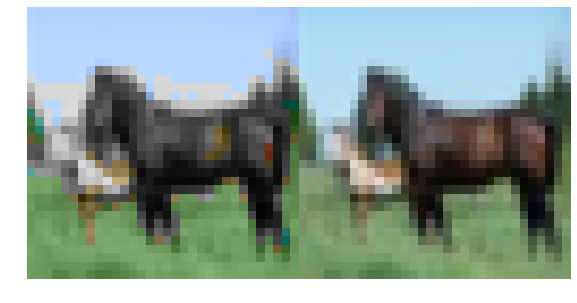

In [34]:
plt.figure(figsize=(10,5))
plt.imshow(np.hstack((reconstruction,im)))
plt.axis('off')

In [5]:
AB=[]

In [6]:
from tqdm import tqdm
#histogram for color rarity
#hist=dict(enumerate(np.zeros(len(bins))))
for i in tqdm(range(1,500)):
    #image=trainloader.dataset.data[i]
    try:
        image=plt.imread('places-test/Places365_val_%08d.jpg'%i)/255
        #image=trainset.data[i]/255
    except FileNotFoundError:
        continue
    labim=color.rgb2lab(image)
    AB.extend(labim[:,:,1:].reshape(-1,2).tolist())
    #used_bins=dist_mat(bins,labim[:,:,1:].reshape(-1,2)).argmin(0)
    #for j in range(len(used_bins)):
    #    hist[used_bins[j]]+=1


100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [00:29<00:00, 16.94it/s]


In [7]:
for i in tqdm(range(20000)):
    #image=trainloader.dataset.data[i]
    try:
        #image=plt.imread('places-test/Places365_val_%08d.jpg'%i)/255
        image=trainset.data[i]/255
    except FileNotFoundError:
        continue
    labim=color.rgb2lab(image)
    AB.extend(labim[:,:,1:].reshape(-1,2).tolist())
    #used_bins=dist_mat(bins,labim[:,:,1:].reshape(-1,2)).argmin(0)
    #for j in range(len(used_b

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:15<00:00, 1329.71it/s]


In [8]:
ab=np.array(AB)

In [9]:
ab.shape

(53051392, 2)

In [10]:
bincount=22
H,xe,ye=np.histogram2d(ab[:,0],ab[:,1],bincount)

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


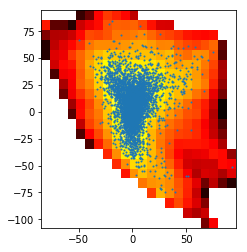

In [11]:
plt.imshow(np.rot90(np.log(H)),extent=(xe.min(),xe.max(),ye.min(),ye.max()),cmap='hot')
plt.scatter(*ab[np.random.permutation(len(ab))][:6000].T,s=1)


In [53]:
numbin=150
Hpr=np.zeros_like(H)
thres=np.sort(H.flatten())[::-1][numbin]
Hpr[H>thres]=H[H>thres]

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


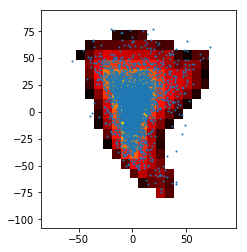

In [54]:
plt.imshow(np.rot90(np.log(Hpr)),extent=(xe.min(),xe.max(),ye.min(),ye.max()),cmap='hot')
plt.scatter(*ab[np.random.permutation(len(ab))][:6000].T,s=1)


In [55]:
binsize=np.array([np.gradient(xe).mean(),np.gradient(ye).mean()])
binsize

array([8.24422678, 9.19706466])

In [56]:
def ind2ab(ind):
    x0=np.array([xe[0],ye[0]])
    return x0+ind*binsize#+binsize/2

In [57]:
x=np.arange(0,bincount)
coord=np.vstack(map(np.ravel, np.meshgrid(x,x))).T

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [59]:
Habfull=ind2ab(coord).reshape(bincount,bincount,2)
Hab=np.zeros_like(Habfull)
Hab[H>thres]=Habfull[H>thres]
bins=Hab[Hab!=np.zeros(2)].reshape(-1,2)

In [60]:
torch.save(torch.from_numpy(bins),'resources/lab_bins.pt')

In [61]:
vflag=H>thres
np.save('resources/labhistogram.npy',H[vflag])

In [62]:
H.shape,x.shape,vflag.shape

((22, 22), (22,), (22, 22))

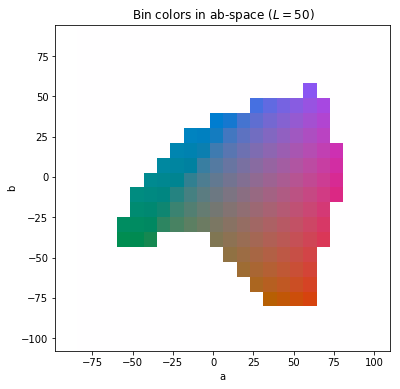

In [77]:
from skimage.transform import pyramid_expand
plt.figure(figsize=(6,6))
L=np.ones((len(x),len(x),1))*50
labspace=np.concatenate((L,Hab),axis=2)#.transpose(2,1,0)

labspace_w=np.ones_like(labspace)*np.array([100,0,0]).reshape(1,1,3)
labspace_w[vflag.reshape(len(x),len(x))]=labspace[vflag.reshape(len(x),len(x))]
rgbrep=color.lab2rgb(labspace_w)
#rgbrep=np.flipud(rgbrep)
#rgbrep=np.rot90(rgbrep,-1);rgbrep=np.fliplr(rgbrep)
#rgbrep=color.lab2rgb(pyramid_expand(labspace_w,(),0,0))
#rgbrep[rgbrep==np.zeros(3)]=np.ones_like(np.count_nonzero(rgbrep==np.zeros(3)))
plt.imshow(rgbrep,extent=(xe.min(),xe.max(),ye.min(),ye.max()))
#plt.imshow(rgbrep,extent=[-labspace.shape[1]*binsize/2, labspace.shape[1]*binsize/2, -labspace.shape[0]*binsize/2, labspace.shape[0]*binsize/2 ])
#plt.plot(labspecfromxyz[:,1]+127,127+labspecfromxyz[:,2],color='k',lw=1)
#plt.plot(labspec[:,1],-labspec[:,2],color='k',lw=1)
plt.axis('equal')
#plt.gca().grid(which='minor', color='w', linestyle='-', linewidth=2)
plt.xlabel('a')
plt.ylabel('b')
plt.title('Bin colors in ab-space $(L=%i)$'%L.flatten()[0])
#plt.savefig('figures/labgamut-bins.pdf')
bins=labspace[vflag.reshape(len(x),len(x))][:,1:]
for i in range(len(bins)):
    ...#plt.text(bins[i][0],bins[i][1],i)
#plt.scatter(*bins.T)
plt.savefig('figures/bincolors.pdf')
plt.show()

abc=bins[3]
plt.imshow(color.yuv2rgb(np.array([.70,abc[0],abc[1]]).reshape(1,1,3)))

In [22]:
from importlib import reload
import functions
reload(functions)
ab2bins=functions.ab2bins

In [23]:
trainset = datasets.CIFAR10(root='./cifar-10', train=True,
                                    download=True, transform=transforms.ToTensor())
im=plt.imread('places-small/Places365_val_00000417.jpg')/255


Files already downloaded and verified


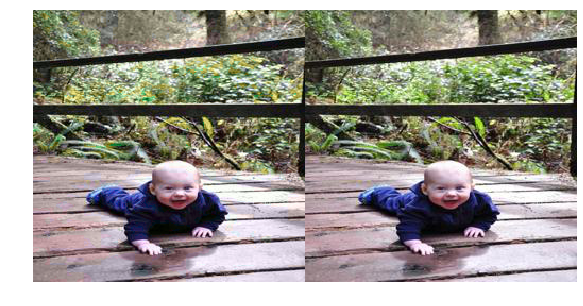

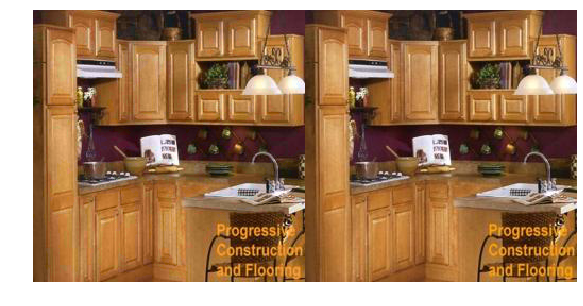

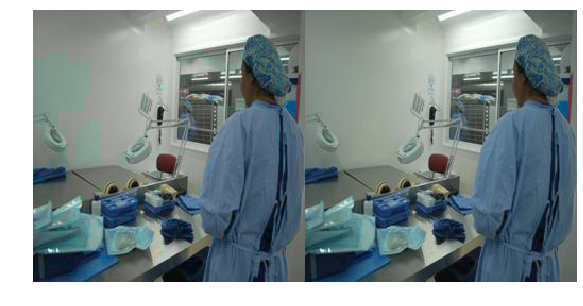

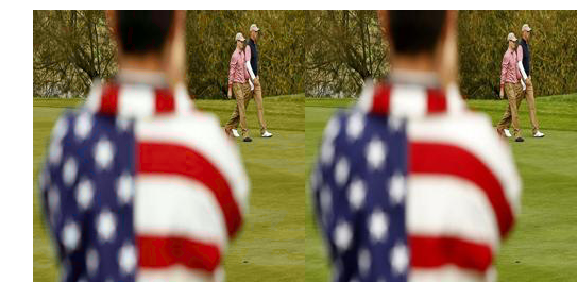

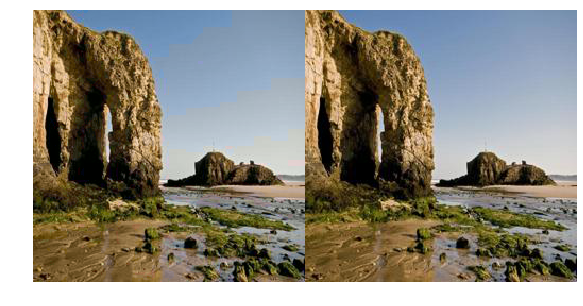

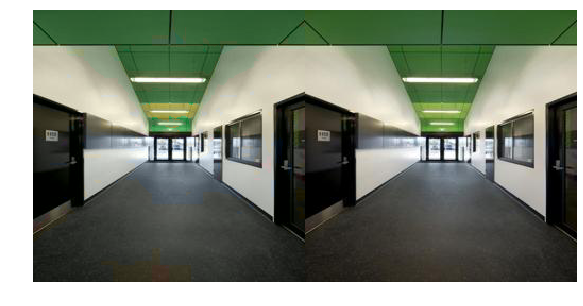

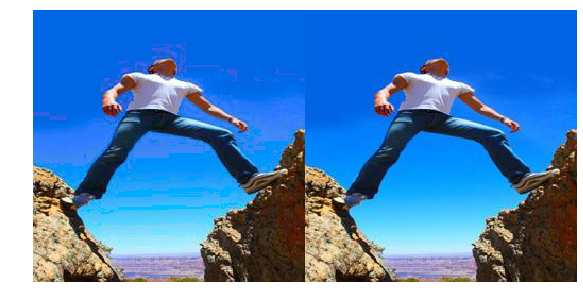

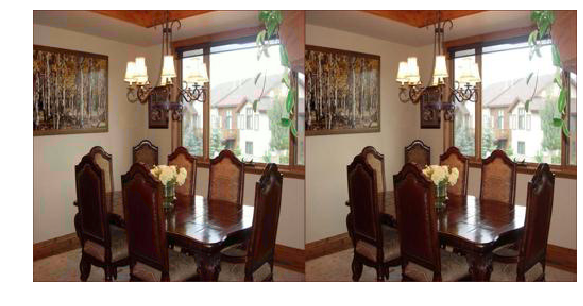

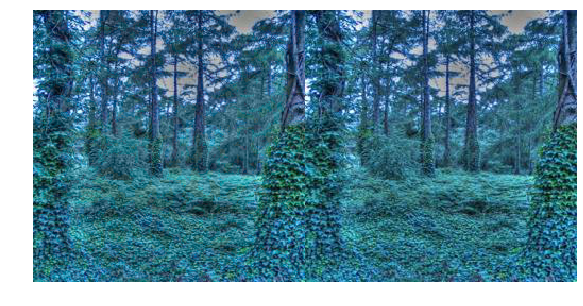

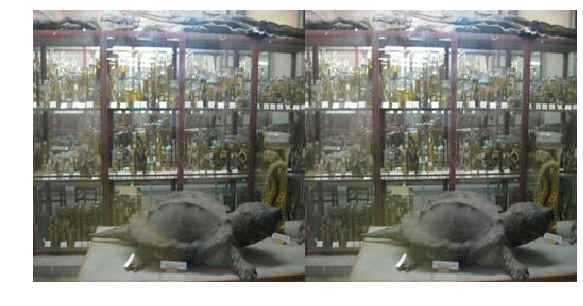

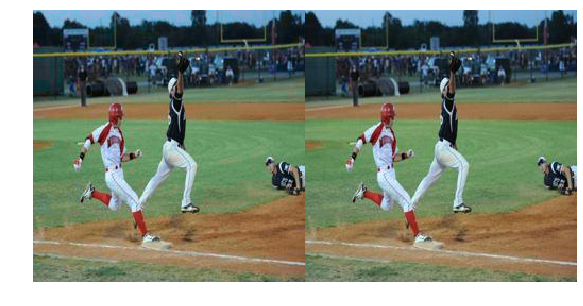

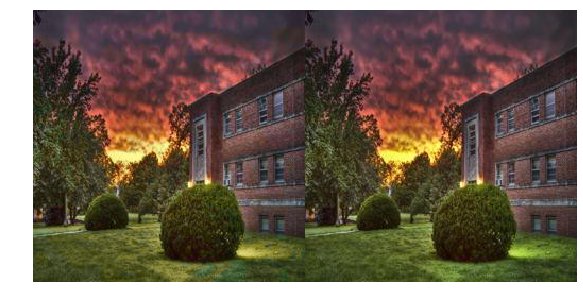

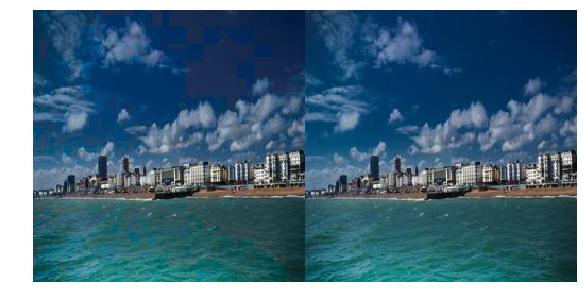

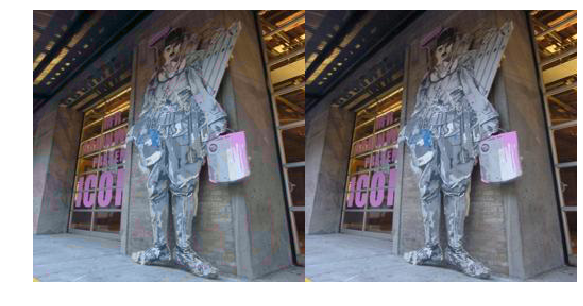

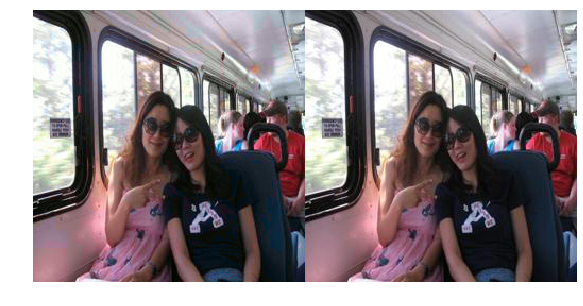

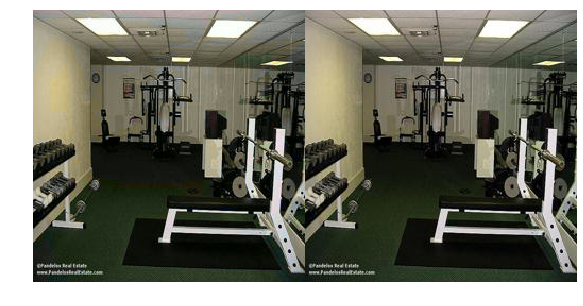

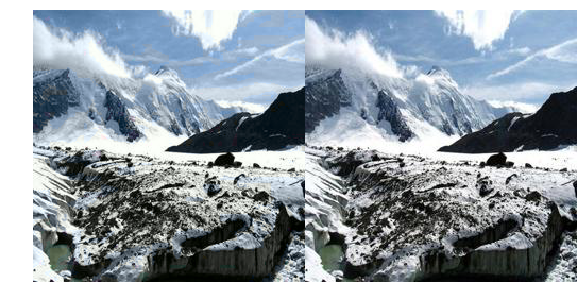

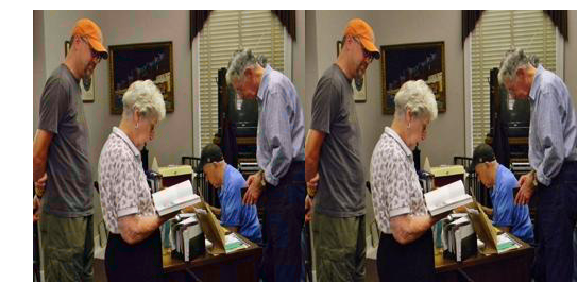

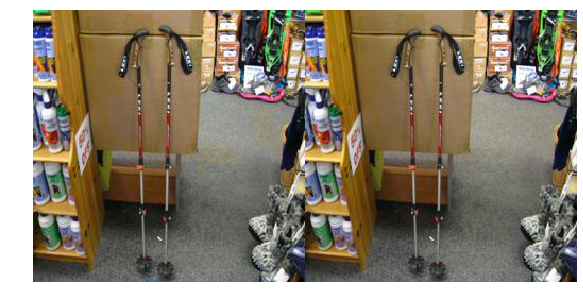

In [40]:
for i in range(1,20):
    #im = trainset.data[i]/255
    im=plt.imread('places-test/Places365_val_%08d.jpg'%i)/255

    lab=color.rgb2lab(im)
    L=lab[:,:,:1]
    Lten=torch.from_numpy(L.transpose((2,0,1))).unsqueeze(0)
    abten=torch.from_numpy(lab[:,:,1:]).unsqueeze(0)
    b=ab2bins(abten,torch.unsqueeze(torch.from_numpy(bins),0))#.cpu()
    aa=bins[b.flatten()].reshape(1,b.shape[2],b.shape[2],2)
    laa=np.concatenate((lab[:,:,0].reshape(1,im.shape[1],-1,1),aa),3)
    reconstruction=color.lab2rgb(laa[0])
    plt.figure(figsize=(10,5))
    plt.imshow(np.hstack((reconstruction,im)))
    plt.axis('off')
    plt.show()

In [24]:
from sklearn.utils import class_weight

In [72]:
count=ab2bins(ab[np.random.permutation(len(ab))[:2000000]],bins[None,...])

In [73]:
np.unique(count).shape

(150,)

In [74]:
weights=class_weight.compute_class_weight('balanced',np.arange(numbin),count.flatten())

In [113]:
torch.save(torch.from_numpy(weights),'resources/class-weights-lab150.pt')

In [84]:
weights=torch.load('resources/class-weights-lab150.pt').numpy()

In [95]:
#weights[weights>13333]=1e4/3

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Text(0, 0.5, 'b')

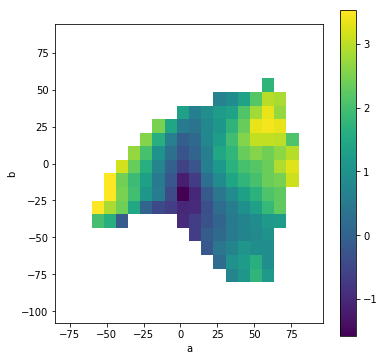

In [111]:
W=np.zeros_like(H)
W[vflag]=weights
plt.figure(figsize=(6,6))
plt.imshow(np.log(W)/np.log(10),extent=(xe.min(),xe.max(),ye.min(),ye.max()))
plt.colorbar()
plt.xlabel('a')
plt.ylabel('b')
#plt.savefig('figures/150labweights.pdf')

In [100]:
def distanceSquaredMatrix(A,B):
    return np.sum(np.square(A[:,None]-B),axis=2)
def K(X1,X2,sig=5):
    dist=distanceSquaredMatrix(X1,X2)
    kernel=np.zeros(dist.shape)
    cutoff=2*sig*np.log(10) #0 when kernel function would be smaller than 0.01
    kernel[dist<cutoff]=np.exp(-dist[dist<cutoff]/(2*sig))
    return kernel

In [105]:
soft=(K(bins,bins,30))

In [109]:
torch.save(torch.from_numpy(soft),'resources/smooth_onehot150.pt')

In [226]:
from models.color_unet import color_unet

In [242]:
import models
color_unet2 = reload(models).color_unet.color_unet

In [243]:
c=color_unet2(classes=42)

In [244]:
from torchsummary import summary

In [245]:
summary(c,(1,32,32),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1            [-1, 1, 16, 16]               0
            Conv2d-2           [-1, 16, 16, 16]             160
       BatchNorm2d-3           [-1, 16, 16, 16]              32
              ReLU-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           2,320
       BatchNorm2d-6           [-1, 16, 16, 16]              32
              ReLU-7           [-1, 16, 16, 16]               0
  double_conv_pool-8           [-1, 16, 16, 16]               0
         MaxPool2d-9             [-1, 16, 8, 8]               0
           Conv2d-10             [-1, 32, 8, 8]           4,640
      BatchNorm2d-11             [-1, 32, 8, 8]              64
             ReLU-12             [-1, 32, 8, 8]               0
           Conv2d-13             [-1, 32, 8, 8]           9,248
      BatchNorm2d-14             [-1, 3

In [256]:
bins[b][0]

array([[[[ 0.03353926, -0.04150938],
         [ 0.03353926, -0.04150938],
         [ 0.03353926, -0.04150938],
         ...,
         [-0.03353926, -0.04150938],
         [-0.03353926, -0.04150938],
         [-0.03353926, -0.04150938]],

        [[ 0.03353926, -0.04150938],
         [ 0.03353926, -0.04150938],
         [ 0.03353926, -0.04150938],
         ...,
         [-0.03353926, -0.04150938],
         [-0.03353926, -0.04150938],
         [-0.03353926, -0.04150938]],

        [[ 0.03353926, -0.04150938],
         [ 0.03353926, -0.04150938],
         [ 0.03353926, -0.04150938],
         ...,
         [-0.10061777, -0.04150938],
         [-0.10061777, -0.04150938],
         [-0.10061777, -0.04150938]],

        ...,

        [[-0.10061777, -0.04150938],
         [-0.10061777, -0.04150938],
         [-0.10061777, -0.04150938],
         ...,
         [-0.10061777, -0.04150938],
         [-0.10061777, -0.04150938],
         [-0.10061777, -0.04150938]],

        [[-0.10061777, -0.04150938

In [30]:
bins=torch.unsqueeze(torch.load('resources/yuv_bins.pt'),0)

In [29]:
binlist=[]

In [30]:
from tqdm import tqdm
#histogram for color rarity
#hist=dict(enumerate(np.zeros(len(bins))))
for i in tqdm(range(1,500)):
    #image=trainloader.dataset.data[i]
    try:
        image=plt.imread('places-test/Places365_val_%08d.jpg'%i)/255
        #image=trainset.data[i]/255
    except FileNotFoundError:
        continue
    labim=color.rgb2yuv(image)
    binlist.extend(yuv2bins(torch.from_numpy(labim[None,:,:,1:]),bins).flatten().tolist())
    #used_bins=dist_mat(bins,labim[:,:,1:].reshape(-1,2)).argmin(0)
    #for j in range(len(used_bins)):
    #    hist[used_bins[j]]+=1


100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [00:23<00:00, 21.09it/s]


In [27]:
for i in tqdm(range(0,len(trainset.data))):
    #image=trainloader.dataset.data[i]
    try:
        #image=plt.imread('places-test/Places365_val_%08d.jpg'%i)/255
        image=trainset.data[i]/255
    except FileNotFoundError:
        continue
    labim=color.rgb2yuv(image)
    binlist.extend(yuv2bins(torch.from_numpy(labim[None,:,:,1:]),bins).flatten().tolist())
    #used_bins=dist_mat(bins,labim[:,:,1:].reshape(-1,2)).argmin(0)
    #for j in range(len(used_b

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1434.59it/s]


In [32]:
len(binlist)

32571392

In [35]:
weights=class_weight.compute_class_weight('balanced',np.arange(42),binlist)

In [36]:
weights

array([1.11584077e+03, 2.37813350e+02, 7.15414514e+02, 9.17762525e+02,
       1.98848547e+02, 2.11656477e+02, 1.74782360e+01, 1.71005366e+02,
       1.17984076e+02, 4.14135071e+01, 7.94375758e+00, 4.80158833e+00,
       1.42848336e+01, 1.42107552e+01, 5.15939946e+01, 1.48875877e+01,
       1.25324715e+01, 2.25714341e+00, 9.28763703e-01, 3.42401832e+00,
       2.53924015e+01, 1.25486947e+03, 4.19380122e+00, 8.41697934e-01,
       1.14050287e-01, 9.98786574e-02, 2.15872592e+00, 1.69465787e+01,
       2.20096306e+01, 3.09270972e+00, 4.82070868e-01, 8.66401718e-02,
       8.57184438e-01, 9.97914549e+00, 3.47371046e+00, 7.19294991e-01,
       1.01222795e+00, 2.33875971e+01, 7.43430315e+00, 1.99540800e+00,
       6.60007943e+02, 1.48795897e+01])

In [42]:
((torch.load('resources/class-weights-yuv.pt').numpy()-weights)/weights).argsort()

array([21,  5, 16,  2,  3, 40, 26, 14, 32,  8, 15, 30, 24,  9, 17, 31, 23,
        7, 41, 28,  1, 18, 36, 35, 22, 39, 27, 25, 29, 34, 10, 19, 37, 38,
       33,  6,  4, 11, 20, 12,  0, 13], dtype=int64)

In [68]:
from importlib import reload
import functions
reload(functions)
yuv2bins=functions.yuv2bins

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


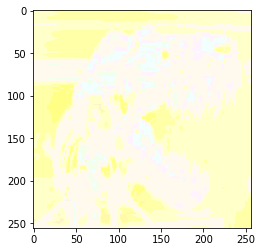

In [81]:
plt.imshow(color.yuv2rgb(functions.bins2yuv(yuv2bins(labim[:,:,1:]),np.ones_like(labim[:,:,:1]))))

In [62]:
labim[None,:,:,1:].reshape(-1,2)

array([[-0.11007076,  0.0480407 ],
       [-0.11007076,  0.0480407 ],
       [-0.11007076,  0.0480407 ],
       ...,
       [-0.15061492,  0.082413  ],
       [-0.15061492,  0.082413  ],
       [-0.15061492,  0.082413  ]])

In [69]:
functions.dist_mat(functions.nbins[0],labim[None,:,:,1:].reshape(-1,2)).shape

(42, 65536)

$$\text{Softmax}(x_{i}) = \frac{exp(x_i)}{\sum_j exp(x_j)}$$

$$x_i=log(z_i)/T$$

In [8]:
x=torch.arange(5).float()+1
torch.nn.functional.softmax(torch.log(x)/1)

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor([0.0667, 0.1333, 0.2000, 0.2667, 0.3333])

In [98]:
from models.color_unet import color_unet
c=color_unet(classes=42)
c.load_state_dict(torch.load('weights/colorunetworkingweight.pth'))
#c.load_state_dict(torch.load('weights/colorunetworkingplaces.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [27]:
from ipywidgets import interactive

In [142]:
im=plt.imread('places-small/Places365_val_00000417.jpg')/255
im = trainset.data[101]/255
lab=color.rgb2yuv(im)
L=lab[:,:,:1]
Lten=torch.from_numpy(L.transpose((2,0,1))).unsqueeze(0)
abten=torch.from_numpy(lab[:,:,1:]).unsqueeze(0)

In [143]:
out=c(Lten.float()-.5)

In [144]:
T=1
outa=torch.nn.functional.softmax(out,1)
outT=torch.nn.functional.softmax(torch.log(outa)/T,1)

In [145]:
def f(k):
    global outT
    plt.figure(2)
    outT=torch.nn.functional.softmax(torch.log(outa)/k,1)
    plt.plot(outT[0,:,0,0].detach().numpy())
    
    plt.show()
    plt.figure(3)
    sample=torch.matmul(outT.transpose(1,2).transpose(2,3),bins.float())
    #img=functions.bins2yuv(sample.detach().numpy(),Lten.numpy())
    sample=torch.cat((Lten.transpose(1,2).transpose(2,3).float(),sample),3)
    plt.imshow(np.clip(color.yuv2rgb(sample.detach().numpy()[0]),0,1))
    plt.show()
interactive_plot= interactive(f,k=(0.01,3))
interactive_plot



interactive(children=(FloatSlider(value=1.5050000000000001, description='k', max=3.0, min=0.01), Output()), _d…

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


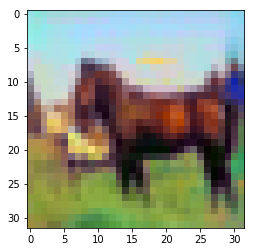

In [80]:
sample=torch.matmul(outT.transpose(1,2).transpose(2,3),bins.float())
#img=functions.bins2yuv(sample.detach().numpy(),Lten.numpy())
sample=torch.cat((Lten.transpose(1,2).transpose(2,3).float(),sample),3)
plt.imshow(color.yuv2rgb(sample.detach().numpy()[0]))

In [73]:
outT.shape,bins.transpose(1,2).shape,outT.transpose(1,2).transpose(2,3).shape,Lten.shape

(torch.Size([1, 42, 32, 32]),
 torch.Size([1, 2, 42]),
 torch.Size([1, 32, 32, 42]),
 torch.Size([1, 1, 32, 32]))

In [155]:
trainset = datasets.STL10(root='stl-10/', split='train+unlabeled',download=False, transform=transforms.ToTensor())

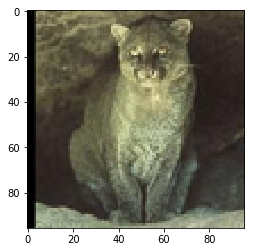

In [160]:
plt.imshow(trainset.data[34].transpose((1,2,0)))

In [174]:
trainset.data[34].shape

(3, 96, 96)

In [195]:
next(iter(loader))[0].shape

KeyboardInterrupt: 

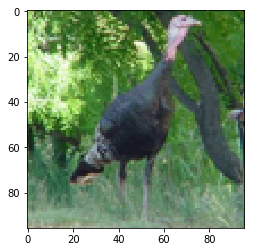

In [185]:
for i,(im,c) in enumerate(loader):
    image=np.transpose(im,(0,2,3,1))
    image=np.transpose(color.rgb2yuv(image),(0,3,1,2))
    image=torch.from_numpy((image-np.array([.5,0,0])[None,:,None,None])).float()
    
    if i==0:
        break

In [2]:
#reload(functions)
from functions import *

In [3]:
#set=load_trainset('places-test',lab=True);dataset=1
set=load_trainset('cifar-10');dataset=0

Files already downloaded and verified


In [4]:
loader=torch.utils.data.DataLoader(set,batch_size=1,num_workers=2)

In [7]:
im=None
for i,batch in enumerate(loader):
            
    if dataset == 0: #cifar 10
        (image,_) = batch
    elif dataset in (1,2): #places
        image = batch

    #batch_size=image.shape[0]
    if dataset == 0: #cifar/stl 10
        image=np.transpose(image,(0,2,3,1))
        image=np.transpose(color.rgb2lab(image),(0,3,1,2))
        image=torch.from_numpy((image-np.array([50,0,0])[None,:,None,None])).float()
    #plt.imshow(color.lab2rgb(np.array([50,0,0])[None,None,:]+image[0].numpy().transpose((1,2,0))))
    im=image.clone()
    break

In [30]:
binab=ab2bins(im[:,1:,:,:].transpose(1,3).transpose(1,2),tbins.cpu())

In [26]:
bab=torch_dist_mat(tbins.cpu(),im.reshape(1,-1,2))#.argmin(1).reshape(1,1,32,-1)

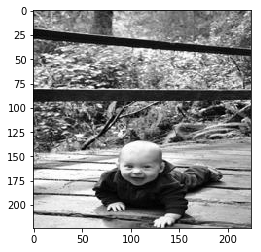

In [25]:
g=x[:,:1,:,:]+.5
plt.imshow(g.numpy()[0,0],cmap='gray')